Acknowledgment to the poster of this data set. Username 'fedesoriano' from [Kaggle.com](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, f1_score, plot_confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB

In [134]:
df = pd.read_csv('PredictStrokes/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [135]:
#This is just to rename the columns because I don't like underscores
df = df.rename(columns = {'heart_disease': 'heartDisease'})
df = df.rename(columns = {'ever_married': 'everMarried'})
df = df.rename(columns = {'work_type': 'workType'})
df = df.rename(columns = {'Residence_type': 'residenceType'})
df = df.rename(columns = {'avg_glucose_level': 'avgGlucoseLevel'})
df = df.rename(columns = {'smoking_status': 'smokingStatus'})

In [136]:
len(df['id'])

5110

## First look at the data
First thing I noticed is that this data set seem pretty small. 5,110 records. I don't have much room to remove data so I'll need to avoid that as much as possible.

Let's check for anything that might cause problems in our data.

In [137]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heartDisease         0
everMarried          0
workType             0
residenceType        0
avgGlucoseLevel      0
bmi                201
smokingStatus        0
stroke               0
dtype: int64

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [139]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [140]:
df['everMarried'].value_counts()

Yes    3353
No     1757
Name: everMarried, dtype: int64

In [141]:
df['workType'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: workType, dtype: int64

In [142]:
df['residenceType'].value_counts()

Urban    2596
Rural    2514
Name: residenceType, dtype: int64

In [143]:
df['smokingStatus'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smokingStatus, dtype: int64

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Here are some places where I see some problems.
 - BMI has 201 records with missing info.
 - gender, hypertension, heartDisease, everMarried, residenceType, and stroke look like their a bianary classification. Simply a 'yes' or 'no' answer. No reason we can't make it a '1' or a '0'
 - workType and smokingStatus seems to be broken up into categories. I see no reason why we couldn't use a category encoder.

## Cleaning the data
Let's go through each one and start to solve the problems that come up, starting with dealing with the NaN values in BMI. Our records only have about 5,000 records to start with so removing 201 records is a lot of data being removed. The safest thing to do without swkeing the data is to take an average of everything in this column and fill in the NaN's with the average.

In [145]:
df = df.fillna(df.mean())
df.isna().sum()

id                 0
gender             0
age                0
hypertension       0
heartDisease       0
everMarried        0
workType           0
residenceType      0
avgGlucoseLevel    0
bmi                0
smokingStatus      0
stroke             0
dtype: int64

Sweet. Simple and clean, like my favorite song. Next, let's deal with the columns that could be a binary answer. Since hyptertension, heartDisease, and stroke are already binary 1's and 0's we can leave them alone. Let's deal with gender and everMarried

In [146]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [147]:
#These are the lists vlaues we want replaced
genderList = ['Male', 'Female']
marriedList = ['No', 'Yes']
residenceList = ['Urban', 'Rural']

In [148]:
#This function takes in a list of old values to find,
# and the specific column name we wish to apply this function to.
#What it returns is the modified df with the column was spcified,
#turned into a binary classification.

def makeBinary(oldList, columnName):
    binaryList = [0, 1]
    newVals = dict(zip(oldList, binaryList))
    return df[columnName].replace(newVals, inplace = True)

makeBinary(genderList, 'gender')

In [149]:
df['gender'].value_counts()

1        2994
0        2115
Other       1
Name: gender, dtype: int64

Shoots, almost. We missed one. Fortunately, removing one row isn't that big a deal, let's just drop them.

In [150]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [151]:
df['gender'].value_counts()

1    2994
0    2115
Name: gender, dtype: int64

Success! Next is married. Second verse, same as the first. We'll apply the makeBinary function to the everMarried column the same way, with the marriedList we set aside earlier.

In [152]:
makeBinary(marriedList, 'everMarried')

In [153]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,Rural,166.29,25.600000,formerly smoked,0


In [154]:
df['everMarried'].value_counts()

1    3353
0    1756
Name: everMarried, dtype: int64

In [155]:
makeBinary(residenceList, 'residenceType')

In [156]:
df['residenceType'].value_counts()

0    2596
1    2513
Name: residenceType, dtype: int64

Success again! Let's move on to starting our model!

# Model 1
So, as we encoding our other columns ('workType' and 'smokingStatus'), we'll be doing that as part of our model.

In [162]:
encoder = ce.CountEncoder(cols = ['workType','smokingStatus'], return_df = True)
scaler = StandardScaler()

xCols = [c for c in df.columns.to_list() if c not in ['stroke']]

x = df[xCols]
y = df['stroke']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainEncoded = encoder.fit_transform(xTrain)
xTestEncoded = encoder.transform(xTest)

print(len(x))
print(xTrain.shape)
print(xTest.shape)
print(len(xTrain + xTest) == len(x))

5109
(3423, 11)
(1686, 11)
True


C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [163]:
xTrainScaled = scaler.fit_transform(xTrainEncoded)
xTestScaled = scaler.transform(xTestEncoded)

model = GaussianNB()
model.fit(xTrainScaled, yTrain)

yPredTrain = model.predict(xTrainScaled)
yPredTest = model.predict(xTestScaled)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")

Accuracy Train Score: 0.8735027753432661
Accuracy Test Score: 0.8600237247924081
F1-Train Score: 0.21129326047358835
F1-Test Score: 0.25316455696202533


Oh geez, that doesn't look good. We're getting a lit of false positives. Let's see if logistic regression has anything different to say.

In [159]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

xCols = [c for c in df.columns.to_list() if c not in ['stroke']]

x = df[xCols]
y = df['stroke']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainEncoded = encoder.fit_transform(xTrain)
xTestEncoded = encoder.transform(xTest)

xTrainScaled = scaler.fit_transform(xTrainEncoded)
xTestScaled = scaler.transform(xTestEncoded)

model = LogisticRegression(random_state = 123)
model.fit(xTrainScaled, yTrain)

yPredTrain = model.predict(xTrainScaled)
yPredTest = model.predict(xTestScaled)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")

Accuracy Train Score: 0.9553023663453112
Accuracy Test Score: 0.9424673784104389
F1-Train Score: 0.0
F1-Test Score: 0.0


C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Um...we made a big error somewhere. This is telling us that we only have false positives. That can't possibly be true. Let's look at our data and see what's going on.

In [164]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,0,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,1,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,1,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,0,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,1,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,0,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,0,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,1,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,1,166.29,25.600000,formerly smoked,0


Train Score: 0.0
-----
Dolar Value Variance: 0.9498923468389118


C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


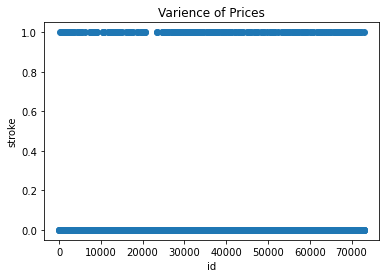

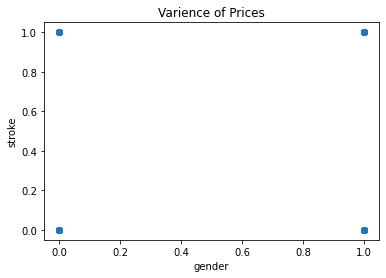

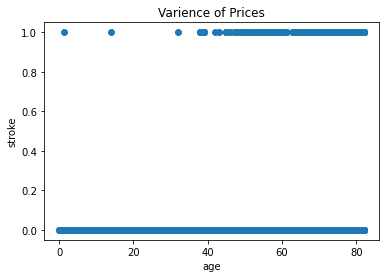

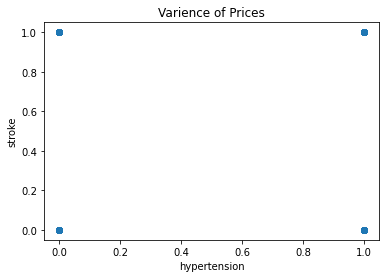

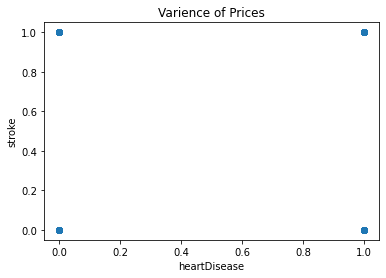

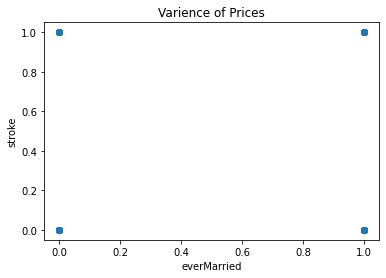

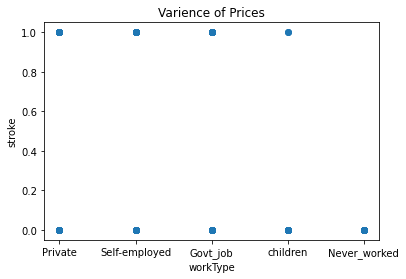

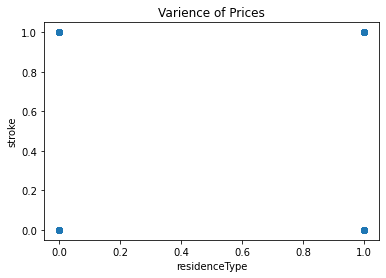

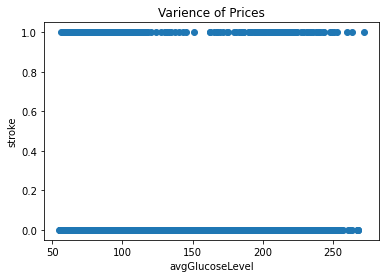

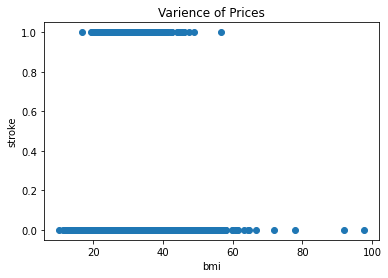

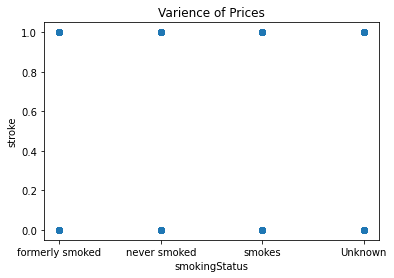

In [173]:
X = df[xCols]
encoder = ce.CountEncoder(cols = ['workType','smokingStatus'], return_df = True)
xEncoded = encoder.fit_transform(X)
model = LogisticRegression(random_state = 123)
model.fit(xEncoded, y)

yPred = model.predict(xEncoded)

print(f"Train Score: {f1_score(y, yPred)}")
print('-----')
print(f"Dolar Value Variance: {accuracy_score(y, yPred)}")

for x in xCols:
    plt.scatter(df[x], df['stroke'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('stroke')
    plt.title('Varience of Prices')
    plt.show()